# Библиотеки и считывание датасета

**Библиотеки**

In [12]:
try:
    import easyocr
except:
    print("[INFO] Couldn't find eacsyocr... installing it.")
    ! pip install easyocr
    import easyocr

In [208]:
# Загружаем нужные библиотеки
import os
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import copy
from torchvision.transforms import functional as F
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision.models as models
import torch
import torch.nn as nn
from collections import defaultdict
from PIL import Image
import easyocr
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from nltk.tokenize import WordPunctTokenizer
import fasttext
from gensim.models import Word2Vec
import gensim.downloader as api
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import catboost

**Считываем и проверяем открытие датасета**

In [14]:
# root_directory = r'/Users/rudy/Downloads/25_80000_student'
root_directory = r'/kaggle/input/25-80000-student/25_80000_student'

In [15]:
directory0 = os.path.join(root_directory, "0")
directory1 = os.path.join(root_directory, "1")
images0_filepaths = sorted([os.path.join(directory0, f) for f in os.listdir(directory0)])
images1_filepaths = sorted([os.path.join(directory1, f) for f in os.listdir(directory1)])

Так как спаммовых слишком много, выч ресурсов не хватает. Я бы мог сделать случайный сабсэмпл нужного размера, однако тогда бы потерялся порядок, а у меня гипотеза, что схожие изображения (аугментированные) находятся близко, а перебирать все не хватает выч ресурсов и времени (речь идет о сутках непрерывных расчетов). Из-за всех этих причин применяем вот такой забавный андерсэмплинг.


In [16]:
images1_filepaths = images1_filepaths[::3]

In [17]:
images0_filepaths = [i for i in tqdm(images0_filepaths) if cv2.imread(i) is not None]
images1_filepaths = [i for i in tqdm(images1_filepaths) if cv2.imread(i) is not None]

100%|██████████| 19923/19923 [04:57<00:00, 67.07it/s]


In [18]:
len(images0_filepaths), len(images1_filepaths)

(19632, 19923)

# Нахождение схожих изображений и train/val

In [61]:
# Сравнивает изображения и визуализирует
def image_matching(path1, path2):
    # Загрузка изображений
    image1 = cv2.imread(path1, 0)
    image2 = cv2.imread(path2, 0)

    # Инициализация детектора и описателей
    detector = cv2.SIFT_create()
    matcher = cv2.BFMatcher()

    # Обнаружение ключевых особенностей и их дескрипторов на изображениях
    keypoints1, descriptors1 = detector.detectAndCompute(image1, None)
    keypoints2, descriptors2 = detector.detectAndCompute(image2, None)

    # Сопоставление особенностей между изображениями
    matches = matcher.match(descriptors1, descriptors2)

    # Сортировка сопоставлений по расстоянию
    matches = sorted(matches, key=lambda x: x.distance)

    # Визуализация сопоставлений
    result = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], None)

    # Отображение результата
    plt.imshow(result)
    plt.show()
    print([round(x.distance) for x in matches[:10]])

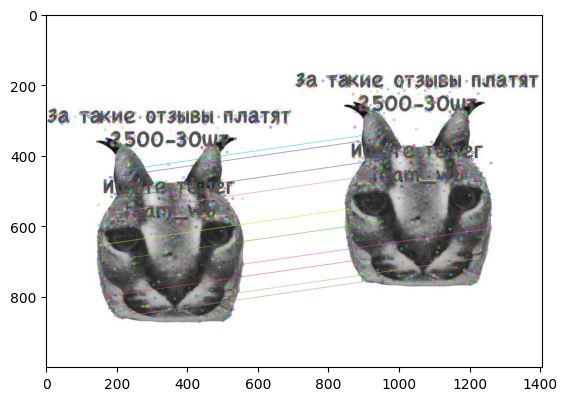

[7, 8, 8, 10, 10, 11, 11, 11, 11, 11]


In [62]:
# Схожие изображения
image_matching(images1_filepaths[7], images1_filepaths[18])

In [63]:
# Поиск аугментаций
def find_augmentations(image_path_lst, threshold):
    image_neighbours_dct = {}
    
    # Initialize detector and matcher objects
    detector = cv2.SIFT_create()
    matcher = cv2.FlannBasedMatcher()
    
    # Load all images and compute descriptors
    images = [cv2.imread(path, 0) for path in image_path_lst]
    keypoints, descriptors = zip(*[detector.detectAndCompute(image, None) for image in images])
    
    for i in tqdm(range(len(image_path_lst))):
        for j in range(i + 1, min(i + 50, len(image_path_lst))):
            # Match descriptors between image1 and image2
            matches = matcher.match(descriptors[i], descriptors[j])
            
            # Sort matches by distance
            matches = sorted(matches, key=lambda x: x.distance)
            
            # Check if the distance of the 10th match is below the threshold
            if matches and (matches[min(len(matches) - 1, 9)].distance < threshold):
                if image_neighbours_dct.get(i) is not None:
                    image_neighbours_dct[i].append(j)
                else:
                    image_neighbours_dct[i] = [j]
    
    return image_neighbours_dct

**Поиск аугментаций**

In [64]:
# augmentations_dct = find_augmentations(images1_filepaths, 20)
# augmentations_np = np.array([*zip(augmentations_dct.keys(), *augmentations_dct.values())][0])
# augmentations_np = np.unique(augmentations_np)
# augmentations_np = np.sort(augmentations_np)
# len(augmentations_np)

In [65]:
# # на случай слета инстанса
# np.savetxt('augmentations_baseline.txt', augmentations_np)

In [66]:
# Открываем файл и считываем данные
# filename = 'augmentations_baseline.txt'
filename = '/kaggle/input/augmentations/augmentations_baseline.txt'
with open(filename, 'r') as file:
    data = file.readlines()

# Преобразуем данные в массив numpy
augmentations_np = np.array([float(line.strip()) for line in data])

# Выводим полученный массив
augmentations_np = augmentations_np.astype(int)
len(augmentations_np)

11165

**Аугментации отправляем в трейн и делим оставшееся**

In [67]:
# Переведем в np.array для использования масок и сабсемплинга
images0_filepaths_np = np.array(images0_filepaths)
images1_filepaths_np = np.array(images1_filepaths)
# Отправим в трейн аугментации
train_images_paths = images1_filepaths_np[augmentations_np]
# Оставим массив без аугментаций
unique_paths = np.setdiff1d(images1_filepaths_np, train_images_paths)
# Дополним трейн спаммом до ровного значения (в трейне 80% значений)
sample_1 = np.random.choice(unique_paths, size=(round(0.8 * len(images1_filepaths_np)) - len(train_images_paths)), replace=False)
train_images_paths = np.concatenate((train_images_paths, sample_1))
# Запишем оставшийся спамм в val
val_images_paths = np.setdiff1d(unique_paths, sample_1, assume_unique=True)

In [68]:
len(train_images_paths), len(val_images_paths)

(15938, 3985)

In [69]:
# Проверим сохранилась ли длина и нет ли пересечений между ссылками
print(f'Количество пересечений train и val = {len(np.intersect1d(train_images_paths, val_images_paths))}')
print(f'Сопвадает ли количество: {(len(train_images_paths) + len(val_images_paths)) == len(images1_filepaths_np)}')

Количество пересечений train и val = 0
Сопвадает ли количество: True


**Добавляем не спам изображения**

In [70]:
sample_1 = np.random.choice(images0_filepaths_np, size=round(0.8 * len(images0_filepaths_np)), replace=False)
sample_2 = np.setdiff1d(images0_filepaths_np, sample_1, assume_unique=True)
train_images_paths = np.concatenate((train_images_paths, sample_1))
val_images_paths = np.concatenate((val_images_paths, sample_2))

In [71]:
# Проверим нет ли пересечений между ссылками у train и val
print(f'Количество пересечений train и val = {len(np.intersect1d(train_images_paths, val_images_paths))}')
print(f'Длины: train - {len(train_images_paths)}, val - {len(val_images_paths)}')

Количество пересечений train и val = 0
Длины: train - 31644, val - 7911


In [72]:
# Перемешаем данные
random.seed(42)
random.shuffle(train_images_paths)
random.shuffle(val_images_paths)

# Считывание слов с изображений

**Пропишем функции считывания слов с изображений, запись их, запись путей и чтение этих данных с файлов**

In [73]:
# Запись в файлы слов с изображения
def words_read_write(paths, reader, filename):
    wrds_lst = []
    
    for image_path in tqdm(paths):
        wrds_lst_lcl = reader.readtext(str(image_path), detail=0)
        wrds_lst.append(wrds_lst_lcl)
    
    with open(filename, "w") as file:
        for item in wrds_lst:
            file.write(str(item) + "\n")

In [74]:
# Считаем слова, которые нашел easyocr на каждой картинке
def read_scanner(filename):
    wrds_list = []

    with open(filename, "r") as inf:
        for line in inf:
            wrds_list.append(line.strip().lower())

    wrds_list = [eval(item) for item in wrds_list]
    
    return wrds_list

In [75]:
# Так как пути каждый раз перемешиваются, их запись
def paths_write(filename, paths):
    with open(filename, "w") as file:
        for item in paths:
            file.write(str(item) + "\n")

In [76]:
# Считывание путей
def paths_scanner(filename):

    pathes = []

    with open(filename, "r") as inf:
        for line in inf:
            pathes.append(line.strip())

    pathes_lcl = [x[48:] for x in pathes]
    pathes = [os.path.join(root_directory, x) for x in pathes_lcl]
    
    return pathes

In [77]:
# Функция для построения изображений и текста к нему
def image_and_text(words_list, path_list, indexes):
    for i in indexes:
        image = cv2.imread(path_list[i], 0)
        plt.imshow(image)
        plt.show()
        print(words_list[i])

**Попробуем русский и русско-английский OCR**

In [78]:
reader_en = easyocr.Reader(['ru', 'en'])
reader = easyocr.Reader(['ru'])

Progress: |██████████████████████████████████████████████████| 100.1% Complete

**Считывание слов с изображений, запись в файлы слов и путей**

**Вал русский**

In [82]:
# words_read(val_images_paths, reader, r'val_reads_ru.txt')
# paths_write(r'val_pathes_ru', val_images_paths)
wrds_val_ru = read_scanner(r'/kaggle/input/pathes-and-reads/val_reads_ru.txt')
pathes_val_ru = paths_scanner(r'/kaggle/input/pathes-and-reads/val_pathes_ru.txt')

**Трейн русский**

In [83]:
# words_read(train_images_paths, reader, r'train_reads_ru.txt')
# paths_write(r'train_pathes_ru.txt', train_images_paths)
wrds_train_ru = read_scanner(r'/kaggle/input/pathes-and-reads/train_reads_ru.txt')
pathes_train_ru = paths_scanner(r'/kaggle/input/pathes-and-reads/train_pathes_ru.txt')

**Посмотрим что вышло**

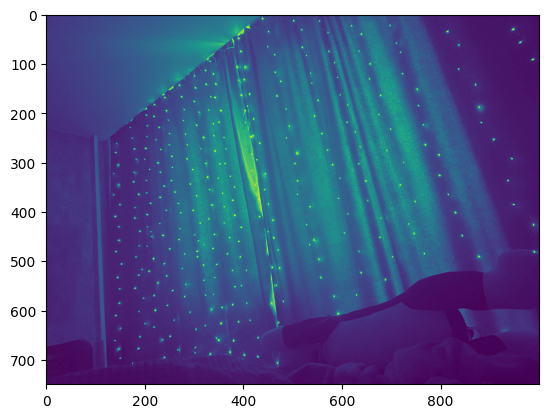

[]


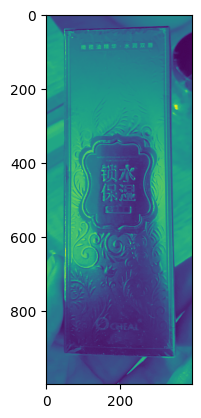

['п##н# кяже', '{$у', ';', "':"]


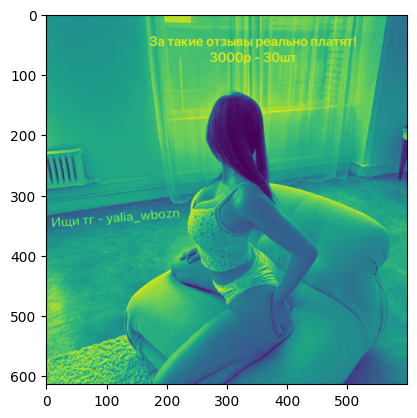

['за такие отзывы реально платят!', 'зооор', 'зошт', 'ищи тг', 'ьоъ', "'уаа"]


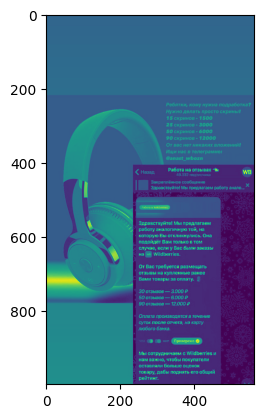

['ребятки; кому нужна подработка?', 'нужно делать просто скрины:', '15 скринов', '1500', '25 скринов', 'зоо0', 'бо скринов', '6000', '90 скринов', '12000', 'от вас нет никаких вложений:', 'ищи нас', 'телеграмме:', '@зшая_ ьо2', 'назад', 'работа на отзывах', 'шв', '49,332 ппдпееечн7', 'закрвплённов ссобщенив', 'здравствуйте} мы предлагаем работу анапо:', '~', '5', 'здравствуйте! мы предлагаем', 'работу аналогичную той, на', 'которую вы откликнулись', 'она', 'подойдёт вам только', 'том', 'случае', 'если', 'вас были заказы', '^фвггвя', 'от вас требуется размещать', 'отзывы на купленные ранее', 'вами тавары за оплату-', '30 отзывов', '000', '50 отзывов', '6.000', '90 стзывов ', '12.000 ₽', 'оплата производится', 'течение', 'суток после отчета; на карту', 'любого банка', 'пацерено', 'мы сотрудничаем', '"`[фыегг\':>', 'нами важно', 'чтобы покупатели', 'оставляли больше оценок', 'товару дабы поднять его общий', 'рейтинг:']


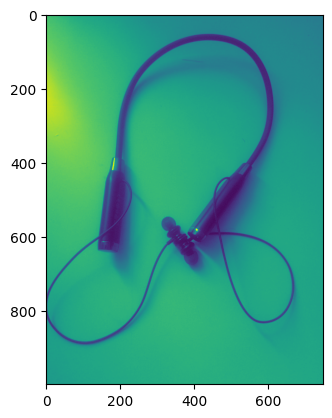

[]


In [92]:
image_and_text(wrds_train_ru, pathes_train_ru, random.sample(range(len(wrds_train_ru)), 5))

**Вал русско-английский**

In [87]:
# words_read(val_images_paths, reader, r'val_reads_ru.txt')
# paths_write(r'val_pathes_ru', val_images_paths)
wrds_val = read_scanner(r'/kaggle/input/pathes-and-reads/val_reads.txt')
pathes_val = paths_scanner(r'/kaggle/input/pathes-and-reads/val_pathes.txt')

**Трейн русско-английский**

In [80]:
# words_read(val_images_paths, reader, r'val_reads_ru.txt')
# paths_write(r'val_pathes_ru', val_images_paths)
wrds_train = read_scanner(r'/kaggle/input/pathes-and-reads/train_reads.txt')
pathes_train = paths_scanner(r'/kaggle/input/pathes-and-reads/train_pathes.txt')

**Посмотрим что вышло**

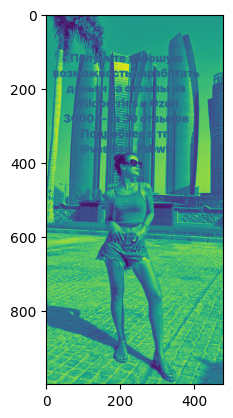

['прлууте 1 , ошую', 'возможшостц', 'zаработату', 'д ныгина & езызы на', '[nilqpe[ri; ,и@zon', 'зооон- еэстзынов', 'пашн=леа е тг |', '@vaslll auw]']


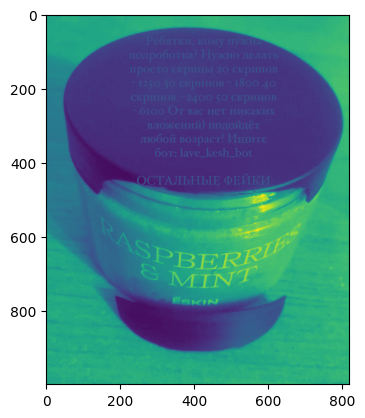

['ребятки; кому нужна', 'подроботка? нужно делать', 'просто скрины 2о скринов', '125030 сринов', '18оо 40', 'скфринов', '2400 50 скринов', 'бтоо отвас нет никаких', 'вложений) подойдёт', 'любой возраст} ищите', 'бот: lave_kesh_bot', 'остальные фейки', '{aspberri"', '8', 'mint', 'lsptu']


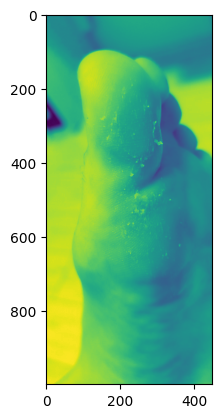

[]


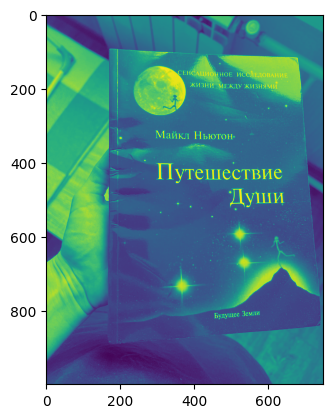

['сенсациокное   исследование', 'жизни   между жизнями', 'майкл ньютон', 'путешествие', 'души', 'будущее земли']


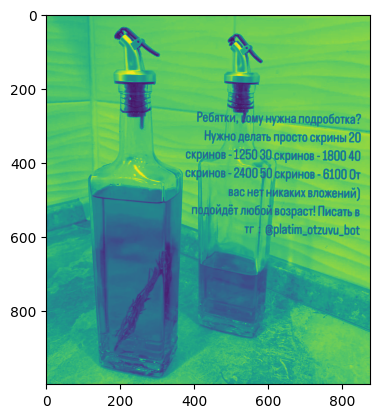

['ребятки; [ому нужна подроботка?', 'нужно делать просто скрины20', 'скринов -12503о скринов -180040', 'скринов -240050 скринов-6100 от', 'вас нет никаких вложений)', 'подойдёт любой возраст! писать в', 'тг', '@platim_otzuvu_bot']


In [95]:
image_and_text(wrds_train, pathes_train, random.sample(range(len(wrds_train)), 5))

# Классификация спамма с заданными "плохими" словами

**Сначала проведем классификацию просто при нахождении в тексте слова из "плохого" списка. Я выделил следующие "плохие" слова**

In [96]:
# Слова, по которым определяется спам
bad_wrds = ["платят", "телег", "тг", "деньги", "работ", "подработк", "скрин",
"tg", "@", "teleg", "bot", "оплат", "пиши", "зарабатыв", "денюж", "вложен", 'ищи']

In [97]:
# Предсказание по "плохим" словам
def bad_words_prediction(image_texts, bad_words):
    # Ответ задачи классификации
    y_pred = np.zeros(len(image_texts))

    # Проверка есть ли слово как часть слов текста каждого изображения
    for i, image_text in enumerate(image_texts):
        for bad_wrd in bad_words:
            for wrd in image_text:
                if bad_wrd in wrd:
                    y_pred[i] = 1
                    break
            if y_pred[i]:
                break

    return y_pred

In [116]:
# Функция получения лейблов
def get_labels(paths):
    labels = np.zeros(len(paths))
    
    for i, path in enumerate(paths):
        if os.path.normpath(path).split(os.sep)[-2] == '1':
            labels[i] = 1.0
            
    return labels

In [236]:
# Функция, печатающая accuracy и f1
def print_metrics(y_true, y_pred, language):
    print(f'{language} OCR: accuracy = {accuracy_score(y_true, y_pred)}, f1 = {f1_score(y_true, y_pred)}')

**Посмотрим метрики после данной классификации с Ru OCR**

In [231]:
# Посмотрим на данных с ru ocr
y_pred = bad_words_prediction(wrds_val_ru, bad_wrds)
y_true = get_labels(pathes_val_ru)
print_metrics(y_true, y_pred, 'Ru')

Ru OCR: accuracy = 0.8782707622298066, f1 = 0.8805655463227087


**Посмотрим метрики после данной классификации с Ru-Eu OCR**

In [232]:
# Посмотрим на данных с ru-eu ocr
y_pred = bad_words_prediction(wrds_val, bad_wrds)
y_true = get_labels(pathes_val)
print_metrics(y_true, y_pred, 'Ru-Eu')

Ru-Eu OCR: accuracy = 0.8861079509543673, f1 = 0.8805198249569023


# Эмбеддинги текстов

**Токенизируем**

In [155]:
# Токанайзер и как он работает
tokenizer = WordPunctTokenizer()
print(' '.join(wrds_val_ru[214]), '\n')
print(tokenizer.tokenize(' '.join(wrds_val_ru[214])))

ребятки кому нужна подроботка? делать просто скрины 20 скринов 1250 30 скринов т800 40 скринов 2400 50 скринов б1оо от вас нет никаких вложений) подойдёт любой возраст! бот: 2афап€_бо€ [остальные фейкиш нужно писать @кошеп+ аиив 

['ребятки', 'кому', 'нужна', 'подроботка', '?', 'делать', 'просто', 'скрины', '20', 'скринов', '1250', '30', 'скринов', 'т800', '40', 'скринов', '2400', '50', 'скринов', 'б1оо', 'от', 'вас', 'нет', 'никаких', 'вложений', ')', 'подойдёт', 'любой', 'возраст', '!', 'бот', ':', '2афап', '€', '_бо', '€', '[', 'остальные', 'фейкиш', 'нужно', 'писать', '@', 'кошеп', '+', 'аиив']


In [156]:
# Получем токеннизированные тексты
tok_val_ru = [tokenizer.tokenize(' '.join(data_entry)) for data_entry in wrds_val_ru]
tok_train_ru = [tokenizer.tokenize(' '.join(data_entry)) for data_entry in wrds_train_ru]
tok_val = [tokenizer.tokenize(' '.join(data_entry)) for data_entry in wrds_val]
tok_train = [tokenizer.tokenize(' '.join(data_entry)) for data_entry in wrds_train]

**Обучим Word2Vec**

In [187]:
# Word2Vec
# Обучаем модели
word2vec = Word2Vec(tok_train,
                 vector_size=32,      # embedding vector size
                 min_count=5,  # consider words that occured at least 5 times
                 window=5).wv  # define context as a 5-word window around the target word

word2vec_ru = Word2Vec(tok_train_ru,
                 vector_size=32,      # embedding vector size
                 min_count=5,  # consider words that occured at least 5 times
                 window=5).wv  # define context as a 5-word window around the target word

In [206]:
word2vec_ru.most_similar('отзыв')

[('получить', 0.8914822340011597),
 ('затакой', 0.8554235696792603),
 ('оставить', 0.8411956429481506),
 ('оставляя', 0.8254228830337524),
 ('можно', 0.8213089108467102),
 ('могут', 0.8159283399581909),
 ('тоже', 0.7851826548576355),
 ('благодарны', 0.781730055809021),
 ('даёте', 0.7728610038757324),
 ('вамтоже', 0.7663962244987488)]

**Решил посмотреть обученный на твитере GloVe, но уже даже по twitter.most_similar('отзыв') понятно, что дальше с ним не стоит лезть, что логично, так как смещение между твитером и нашими текстами скорее всего огромное**

In [ ]:
twitter = api.load('glove-twitter-100')

In [180]:
twitter.most_similar('отзыв')

[('комментарий', 0.6192041039466858),
 ('годовой', 0.5955293774604797),
 ('рассказ', 0.5887763500213623),
 ('заявление', 0.5730368494987488),
 ('бумажный', 0.5706899166107178),
 ('ходатайство', 0.569583535194397),
 ('портрет', 0.5684971809387207),
 ('документ', 0.5668075680732727),
 ('социальный', 0.5642455220222473),
 ('письмо', 0.5630896091461182)]

**Построим эмбеддинги текстов**

In [191]:
# Эмбеддинг для текста
def get_phrase_embedding(tokens, model):
    """
    Convert phrase to a vector by aggregating it's word embeddings. See description above.
    """
    # 1. lowercase phrase
    # 2. tokenize phrase
    # 3. average word vectors for all words in tokenized phrase
    # skip words that are not in model's vocabulary
    # if all words are missing from vocabulary, return zeros

    vector = np.zeros([model.vector_size], dtype='float32')
    dct_count = Counter(tokens)
    
    tokens = [word for word in tokens if word in model]
    dct_tok  = {token: model.get_vector(token) for token in tokens}

    for tok in dct_tok:
        vector += dct_tok[tok] * dct_count[tok] / len(tokens)

    return vector

**Получим эмбеддинги текстов и таргеты для всех выборок**

In [207]:
# Получим эмбеддинги для всех выборок
vectors_train = np.array([get_phrase_embedding(phrase, word2vec) for phrase in tok_train])
vectors_val = np.array([get_phrase_embedding(phrase, word2vec) for phrase in tok_val])
vectors_train_ru = np.array([get_phrase_embedding(phrase, word2vec_ru) for phrase in tok_train_ru])
vectors_val_ru = np.array([get_phrase_embedding(phrase, word2vec_ru) for phrase in tok_val_ru])

In [216]:
# Получим таргеты
y_train = get_labels(pathes_train)
y_val = get_labels(pathes_val)
y_train_ru = get_labels(pathes_train_ru)
y_val_ru = get_labels(pathes_val_ru)

# Классификация на основе эмбеддингов

**На основе эмбеддингов воспользуемся базовыми классификаторами: Logistic Regression, Random Forest, Gradient Boosting (я взял catboost)**

In [233]:
# Прогоним через LogReg, RF, GB
def classifiers_embeddings(x_train, y_train, x_val, y_val, language):
    logreg = LogisticRegression(max_iter=5000)
    logreg.fit(x_train, y_train)
    print('LogReg')
    print_metrics(y_val, logreg.predict(x_val), language)
    print()
    
    rf = RandomForestClassifier()
    rf.fit(x_train, y_train)
    print('RandomForest')
    print_metrics(y_val, rf.predict(x_val), language)
    print()

    boosting = catboost.CatBoostClassifier(verbose=False)
    boosting.fit(x_train, y_train, verbose=False)
    print('CatBoost')
    print_metrics(y_val, boosting.predict(x_val), language)

**Посмотрим как сработали классификаторы после Ru-Eu OCR**

In [234]:
# Для Ru-Eu
classifiers_embeddings(vectors_train, y_train, vectors_val, y_val, 'Ru-Eu')

LogReg
Ru-Eu OCR: accuracy = 0.8931867020604222, f1 = 0.8852058144273877

RandomForest
Ru-Eu OCR: accuracy = 0.9124004550625711, f1 = 0.9064651100013498

CatBoost
Ru-Eu OCR: accuracy = 0.9151813929970927, f1 = 0.9099449738290162


**Посмотрим как сработали классификаторы после Ru OCR**

In [235]:
# Для Ru
classifiers_embeddings(vectors_train_ru, y_train_ru, vectors_val_ru, y_val_ru, 'Ru')

LogReg
Ru OCR: accuracy = 0.8840854506383516, f1 = 0.8744007670182167

RandomForest
Ru OCR: accuracy = 0.9062065478447731, f1 = 0.8989651416122004

CatBoost
Ru OCR: accuracy = 0.9092402983187966, f1 = 0.9031823085221142


# Итог

**В качестве baselines были выбраны комбинации моделей: Ru/Ru-Eu easyOCR * Классификатор по "плохим" словам/(word2vec + LogReg/Random Forest/CatBoost).**

**Метрикой качества была выбрана F1-мера, так как она устойчива к несбалансированности классов (как всегда происходит в задачах со спамом) и позволяет учитывать баланс между precision и recall, что так же важно, чтобы поймать баланс между поимкой спама среди спамов и ложного отправления в спам среди обычных отзывов.**

**Итого, лучший по f1 baseline: Ru-Eu OCR + word2vec + CatBoost, c f1 =0.9099449738290162**